In [239]:
# pip install --upgrade spacy

In [240]:
# !python -m spacy download en_core_web_md

In [241]:
# pip install podium-nlp

In [242]:
# pip install hdbscan

In [243]:
# pip install bertopic

In [244]:
# pip install emoji

In [245]:
# pip install wordsegment

In [246]:
# pip install ekphrasis -U

In [251]:
# !pip install k-means-constrained

You should consider upgrading via the 'c:\users\marino pc\desktop\apt\scripts\python.exe -m pip install --upgrade pip' command.



  Using cached k_means_constrained-0.7.1-cp39-cp39-win_amd64.whl (357 kB)
  Using cached ortools-9.3.10497-cp39-cp39-win_amd64.whl (40.5 MB)
  Using cached absl_py-1.1.0-py3-none-any.whl (123 kB)


In [2]:
from tqdm import tqdm
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from bertopic import BERTopic
from podium import Vocab, Field, LabelField
from podium.datasets import TabularDataset
from podium.vectorizers import GloVe
from nltk.sentiment import SentimentIntensityAnalyzer
from copy import deepcopy
from nltk.tokenize.casual import TweetTokenizer
from time import time
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.segmenter import Segmenter
#from k_means_constrained import KMeansConstrained
from gensim.models import CoherenceModel

import contextualSpellCheck
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
import emoji
import warnings
warnings.filterwarnings("ignore")

In [249]:
# from google.colab import drive
# drive.mount('/content/drive')

In [250]:
# %cd drive/MyDrive/datasets/

# Preprocessing

In [3]:
nlp = spacy.load("en_core_web_md")

In [4]:
df = pd.read_csv("train/SemEval2018-T3-train-taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_test = pd.read_csv("goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_replace = pd.read_csv("test_TaskA/SemEval2018-T3_input_test_taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')

In [5]:
df.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)
df_test.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)
df_replace.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)

## Getting clean text

In [6]:
tokenizer = TweetTokenizer(preserve_case=True, reduce_len=True, strip_handles=True)
df_tmp = df['Tweet text'].apply(tokenizer.tokenize)
df_test_tmp = df_test['Tweet text'].apply(tokenizer.tokenize)

In [7]:
def emoji_counter(s):
    return len(emoji.emoji_lis(s))

df['emoji_count'] = df['Tweet text'].apply(emoji_counter)
df_test['emoji_count'] = df_test['Tweet text'].apply(emoji_counter)

In [8]:
# seg_eng = Segmenter(corpus="english") 
seg_tw = Segmenter(corpus="twitter")

Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [9]:
def separate_hashtags(s):
    '''Removes the hashtag sign and segments the hashtag text.'''
    hashtags = []
    
    l = []
    for i, s_i in enumerate(s):
        if s_i.startswith('#'):
            tmp = tokenizer.tokenize(seg_tw.segment(s_i.replace('#', '')))
            l.extend(tmp)
        else:
            l.append(s_i)
    return l
            
df_tmp = df_tmp.apply(separate_hashtags)
df_test_tmp = df_test_tmp.apply(separate_hashtags)

In [10]:
def preprocess_words(s):
    '''
    Removes tags, emojis, links, smiley faces, | signs, stopwords and changes the case to lower.
    '''
    ret_list = []

    smiley_regex = r'([\:\;\=][()PDO\/\]\[p|]+)+'
    
    is_tag = lambda w: w.startswith('@')
    is_vertical_line = lambda w: w.startswith('|')
    is_emoji = lambda w: emoji.is_emoji(w)
    is_link = lambda w: w.startswith("http") or w.startswith("https")
    is_hashtag = lambda w: w.startswith("#")
    is_smiley = lambda w: re.match(smiley_regex, w)

    w2 = []
    for i, w in enumerate(s):
        if is_tag(w) or is_emoji(w) or is_link(w) or is_vertical_line(w):
            continue

        elif is_hashtag(w):
            w_tmp = w.replace('#', '')
            if w_tmp != '':
                lower_append(w_tmp, w2)

        elif is_smiley(w):
            w_tmp = re.sub(smiley_regex, '', w)
            if w_tmp != '':
                lower_append(w_tmp, w2)

        else:
            w_tmp = w.replace('#', '')
            w_tmp = w_tmp.replace('|', '')
            w_tmp = w_tmp.replace('_', '')
            w_tmp = w_tmp.replace('...', '')
            if w_tmp != '':
                lower_append(w_tmp, w2)

    return ' '.join([i for i in w2 if len(i) > 2])

def lower_append(w, l):
    l.append(w.lower())

df['clean_text'] = df_tmp.apply(preprocess_words)
df_test['clean_text'] = df_test_tmp.apply(preprocess_words)

In [11]:
print(df.shape)
df.head(15)

(3817, 5)


,Tweet index,Label,Tweet text,emoji_count,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather
3,4,0,3 episodes left I'm dying over here\r,0,episodes left i'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day


In [12]:
print(df.shape)
df.head(15)

(3817, 5)


,Tweet index,Label,Tweet text,emoji_count,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather
3,4,0,3 episodes left I'm dying over here\r,0,episodes left i'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day


In [13]:
df_tmp2 = df['clean_text'].copy()

In [14]:
def remove_tuple_characters(s):
    return [re.sub(r'(.)\1{2,}', r'\1', w) for w in s]

df['clean_text'] = df[['clean_text']].apply(remove_tuple_characters)
df_test['clean_text'] = df_test[['clean_text']].apply(remove_tuple_characters)

print(df.shape)
df.head(15)

(3817, 5)


,Tweet index,Label,Tweet text,emoji_count,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather
3,4,0,3 episodes left I'm dying over here\r,0,episodes left i'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day


In [15]:
def lemmatize(s):
    '''Lemmatizes the words in the sentences and returns them if theyre not stopwords or punctuation'''
    return [[w.lemma_.lower() for w in nlp(s_i) if w.lemma_.lower() not in nlp.Defaults.stop_words and not w.is_punct] for s_i in s]

df['lemmas'] = df[['clean_text']].apply(lemmatize)
df_test['lemmas'] = df_test[['clean_text']].apply(lemmatize)

In [16]:
print(df.shape)
df = df[df['lemmas'].apply(lambda x: len(x)) > 0]
print(df.shape)

(3817, 6)
(3795, 6)


In [17]:
df.head(15)

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...,"[sweet, united, nations, video, time, christma..."
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...,"[rumor, talk, erv, agent, angel, ask, escobar,..."
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather,"[hey, nice, minnesota, winter, weather]"
3,4,0,3 episodes left I'm dying over here\r,0,episodes left i'm dying over here,"[episode, leave, die]"
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...,"[breathe, choose, notable, quote, year, annual..."
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas,"[old, footie, pajama]"
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...,"[happy, highway, break, light, light, like, ch..."
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day,"[4:30, open, beer, going, long, night, day]"
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...,"[think, support, guy, knock, daughter, rice, d..."
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day,"[allow, open, christmas, day]"


In [18]:
### baseline features ###
tokenizer2 = TweetTokenizer()
def word_counter(s):
    return len([x for x in tokenizer.tokenize(s)])

def char_counter(s):
    return len(s.replace(' ', ''))

def all_uppercase_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.isupper() and not x.startswith(("@", "#", "http"))])

def all_lowercase_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.islower() and not x.startswith(("@", "#", "http"))])

def capitalised_counter(s):
    return sum([i.istitle() for i in tokenizer2.tokenize(s)])

def digit_counter(s):
    return sum([i.isdigit() for i in s])



### other features ###
def tag_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.startswith("@")])

def hashtag_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.startswith("#")])

def link_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.startswith(('http:', 'https:'))])

def smiley_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if re.match(r'([\:\;\=][()PDO\/\]\[p|]+)+', x)])

def exclamation_mark_counter(s):
    return s.count('!')

def question_mark_counter(s):
    return s.count('?')

def ellipsis_counter(s):
    return s.count('...')
    


### NER ###
def ORG_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'ORG'])

def NORP_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'NORP'])

def GPE_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'GPE'])

def PERSON_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'PERSON'])

In [19]:
def add_features(some_df):
    some_df['word_count'] = some_df['clean_text'].apply(word_counter)
    some_df['char_count'] = some_df['clean_text'].apply(char_counter)
    some_df['all_uppercase_count'] = some_df['Tweet text'].apply(all_uppercase_counter)
    some_df['all_lowercase_count'] = some_df['Tweet text'].apply(all_lowercase_counter)
    some_df['capitalised_count'] = some_df['Tweet text'].apply(capitalised_counter)
    some_df['digit_count'] = some_df['Tweet text'].apply(digit_counter)
    
    some_df['tag_count'] = some_df['Tweet text'].apply(tag_counter)
    some_df['hashtag_count'] = some_df['Tweet text'].apply(hashtag_counter)
    some_df['link_count'] = some_df['Tweet text'].apply(link_counter)
    some_df['smiley_count'] = some_df['Tweet text'].apply(smiley_counter)
    
    some_df['exclamation_mark_count'] = some_df['Tweet text'].apply(exclamation_mark_counter)
    some_df['question_mark_count'] = some_df['Tweet text'].apply(question_mark_counter)
    some_df['ellipsis_count'] = some_df['Tweet text'].apply(ellipsis_counter)
    
    some_df['ORG_tag_count'] = some_df['Tweet text'].apply(ORG_tag_counter)
    some_df['NORP_tag_count'] = some_df['Tweet text'].apply(NORP_tag_counter)
    some_df['GPE_tag_count'] = some_df['Tweet text'].apply(GPE_tag_counter)
    some_df['PERSON_tag_count'] = some_df['Tweet text'].apply(PERSON_tag_counter)
    
add_features(df)
add_features(df_test)

In [20]:
df.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,hashtag_count,link_count,smiley_count,exclamation_mark_count,question_mark_count,ellipsis_count,ORG_tag_count,NORP_tag_count,GPE_tag_count,PERSON_tag_count
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...,"[sweet, united, nations, video, time, christma...",10,58,0,4,...,2,1,0,0,0,0,1,0,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...,"[rumor, talk, erv, agent, angel, ask, escobar,...",15,78,0,14,...,0,0,1,0,0,2,1,0,0,2
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather,"[hey, nice, minnesota, winter, weather]",8,40,1,4,...,0,0,0,1,0,0,0,0,1,0
3,4,0,3 episodes left I'm dying over here\r,0,episodes left i'm dying over here,"[episode, leave, die]",6,28,0,5,...,0,0,0,0,0,0,0,0,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...,"[breathe, choose, notable, quote, year, annual...",16,88,1,20,...,0,0,0,1,0,0,1,0,0,0


In [21]:
df_train = df.sample(frac=0.7)
df_validation = df.drop(df_train.index)

In [22]:
df_train.reset_index(inplace=True, drop=True)
df_validation.reset_index(inplace=True, drop=True)

In [23]:
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,hashtag_count,link_count,smiley_count,exclamation_mark_count,question_mark_count,ellipsis_count,ORG_tag_count,NORP_tag_count,GPE_tag_count,PERSON_tag_count
0,2599,0,"Buzzing about going home tonight, back for a m...",0,buzzing about going home tonight back for month,"[buzz, home, tonight, month]",8,40,0,8,...,0,0,0,0,0,0,0,0,0,0
1,2618,1,Agree with @FrankFerragine @BTtoronto some peo...,0,agree with some people sigh others will hear t...,"[agree, people, sigh, hear, husband, sigh, tim...",16,76,0,15,...,1,0,0,0,0,0,0,0,0,0
2,1560,1,Working hard right now http://t.co/ZrW0j1TgNt\r,0,working hard right now,"[work, hard, right]",4,19,0,3,...,0,1,0,0,0,0,0,0,0,0
3,1473,0,You'd hope that a film like that would lose re...,0,you'd hope that film like that would lose rele...,"[hope, film, like, lose, relevance, couple, de...",14,68,0,15,...,0,0,0,0,0,0,0,0,0,0
4,400,0,just pulled up to school for the first time in...,0,just pulled school for the first time life goo...,"[pull, school, time, life, good, mood, find, s...",19,87,0,26,...,1,0,0,0,0,0,0,0,0,0


In [24]:
def new_df_with_all_features(df1, df2):
    cols_to_add = list(set(df2.columns.tolist()) - set(df1.columns.tolist()))
    if 'Tweet index' in cols_to_add:
        cols_to_add.remove('Tweet index')
    new_df = pd.concat((df1.copy(), df2[cols_to_add]), axis=1)
    return new_df

In [25]:
def join_docs(s):
    '''Joins the strings inside the inner list of a nested list'''
    return ' '.join(s)

df_train['topic_text'] = df_train['lemmas'].apply(join_docs)
df_validation['topic_text'] = df_validation['lemmas'].apply(join_docs)
df_test['topic_text'] = df_test['lemmas'].apply(join_docs)

In [26]:
df_train.shape

(2656, 24)

In [27]:
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,link_count,smiley_count,exclamation_mark_count,question_mark_count,ellipsis_count,ORG_tag_count,NORP_tag_count,GPE_tag_count,PERSON_tag_count,topic_text
0,2599,0,"Buzzing about going home tonight, back for a m...",0,buzzing about going home tonight back for month,"[buzz, home, tonight, month]",8,40,0,8,...,0,0,0,0,0,0,0,0,0,buzz home tonight month
1,2618,1,Agree with @FrankFerragine @BTtoronto some peo...,0,agree with some people sigh others will hear t...,"[agree, people, sigh, hear, husband, sigh, tim...",16,76,0,15,...,0,0,0,0,0,0,0,0,0,agree people sigh hear husband sigh time curious
2,1560,1,Working hard right now http://t.co/ZrW0j1TgNt\r,0,working hard right now,"[work, hard, right]",4,19,0,3,...,1,0,0,0,0,0,0,0,0,work hard right
3,1473,0,You'd hope that a film like that would lose re...,0,you'd hope that film like that would lose rele...,"[hope, film, like, lose, relevance, couple, de...",14,68,0,15,...,0,0,0,0,0,0,0,0,0,hope film like lose relevance couple decade nope
4,400,0,just pulled up to school for the first time in...,0,just pulled school for the first time life goo...,"[pull, school, time, life, good, mood, find, s...",19,87,0,26,...,0,0,0,0,0,0,0,0,0,pull school time life good mood find start hou...


## Topic modeling baselines

In [276]:
count_vectorizer = CountVectorizer(
    analyzer='word',
    min_df=20,
    max_df=0.5,
)

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    min_df=20,
    max_df=0.5,
)

tweet_text_count_train = count_vectorizer.fit_transform(df_train['topic_text'])
tweet_text_count_validation = count_vectorizer.transform(df_validation['topic_text'])
tweet_text_count_test = count_vectorizer.transform(df_test['topic_text'])

tweet_text_tfidf_train = tfidf_vectorizer.fit_transform(df_train['topic_text'])
tweet_text_tfidf_validation = tfidf_vectorizer.transform(df_validation['topic_text'])
tweet_text_tfidf_test = tfidf_vectorizer.transform(df_test['topic_text'])

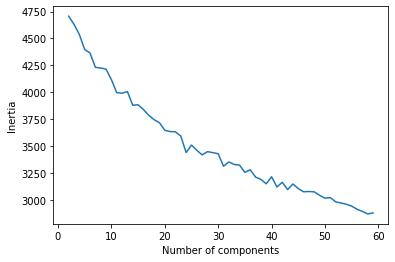

In [277]:
inertia = []
range_ = list(range(2, 60))
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_count_train)
    inertia.append(model.inertia_)
    
plt.plot(range_, inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

In [278]:
from gensim import corpora

texts = [l for l in df_train['lemmas']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

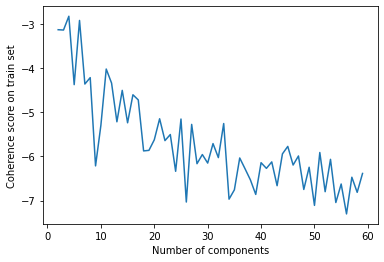

In [279]:
def calc_coherence(model, y_train, y_val, length=4):
    # count words and create a dictionary of occurences
    occurences = {i:0 for i in range(0, max(y_train)+1)}
    for i in occurences.keys():
        occurences[i] = (y_train == i).sum()
    sorted_occ_keys = sorted(occurences, key=occurences.get, reverse=True)

    # find most often used words
    keys_max_count_all = []
    for k in sorted_occ_keys:
        indices = np.where(y_train == k)[0]
        l_words = []
        for l in df_train['lemmas'][indices].values.tolist():
            l_words.extend(l)
        d = {i: l_words.count(i) for i in set(l_words)}
        keys_max_count = sorted(d, key=d.get, reverse=True)[:length]
        keys_max_count_all.append(keys_max_count)
        
    # coherence calculation
    cm = CoherenceModel(topics=keys_max_count_all, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherence = cm.get_coherence()
    return coherence

coherences = []
range_ = list(range(2, 60))
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_count_train)
    
    kmeans_count_labels_train = model.predict(tweet_text_count_train)
    kmeans_count_labels_validation = model.predict(tweet_text_count_validation)
    kmeans_count_labels_test = model.predict(tweet_text_count_test)

    coh = calc_coherence(model, kmeans_count_labels_train, kmeans_count_labels_validation)
    coherences.append(coh)
    
plt.plot(range_, coherences)
plt.xlabel('Number of components')
plt.ylabel('Coherence score on train set')
plt.show()

In [280]:
print(f'Coherence max: {[(i+2, c) for i, c in enumerate(coherences) if c == max(coherences)]}')

Coherence max: [(4, -2.8304392776468106)]


In [281]:
model = KMeans(5)
model.fit(tweet_text_count_train)

kmeans_count_labels_train = model.predict(tweet_text_count_train)
kmeans_count_labels_validation = model.predict(tweet_text_count_validation)
kmeans_count_labels_test = model.predict(tweet_text_count_test)

In [282]:
occurences = {i:0 for i in range(max(kmeans_count_labels_train))}
for i in occurences.keys():
    occurences[i] = (kmeans_count_labels_train == i).sum()
    
sorted_occ_keys = sorted(occurences, key=occurences.get, reverse=True)

for i in range(3):
    indices = np.where(kmeans_count_labels_train == i)[0]
    indices_random = np.random.randint(0, len(indices), size=3)
    [print(df_train['Tweet text'][i]) for i in indices_random.tolist()]
    print()

I love how when I'm stressed my body decides to react by causing me massive pain. 
Hey what do you know, one of the witnesses supporting Darren Wilson's story lied! And is racist! Mind blown! http://t.co/0k25FE024w 
@SincerelyTumblr: One day I want to travel with my bestfriend 🌏✈️ http://t.co/AXD3Ax5qC1 DONE DID TRAVELED DA WORLD!! @Bethanycsmithh ❤️

love being able to be comfortable in my own room😃👍 
#New#color#new#beginning#new#goals#dont#giveup#never#life#should#be#easy @ skdar http://t.co/bzmXE0K98i
Produce all kinds of Creative Designs #like15| http://t.co/OXeuznMhY8 http://t.co/w4eZ9mObFJ

@oneplanetmikey @misskylie77 I had never heard of them before, but I quite liked it!
Love coming to school knowing I have tests all day 
you is very much right my brother when I am done I still will not have a car, and when I am done praising Allah I to will still  (1/2)



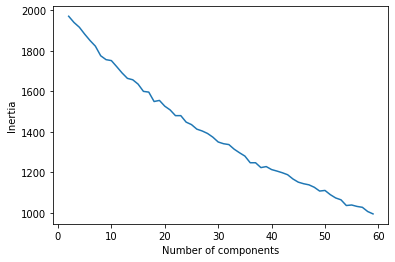

In [283]:
inertia = []
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_tfidf_train)
    inertia.append(model.inertia_)
plt.plot(range_, inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

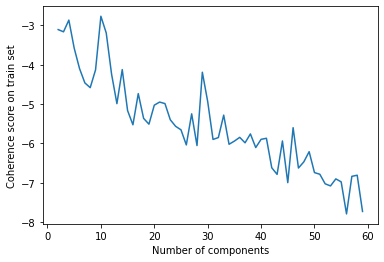

In [284]:
coherences = []
range_ = list(range(2, 60))
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_tfidf_train)
    
    kmeans_tfidf_labels_train = model.predict(tweet_text_tfidf_train)
    kmeans_tfidf_labels_validation = model.predict(tweet_text_tfidf_validation)
    kmeans_tfidf_labels_test = model.predict(tweet_text_tfidf_test)

    coh = calc_coherence(model, kmeans_tfidf_labels_train, kmeans_tfidf_labels_validation)
    coherences.append(coh)
    
plt.plot(range_, coherences)
plt.xlabel('Number of components')
plt.ylabel('Coherence score on train set')
plt.show()

In [285]:
print(f'Coherence max: {[(i+2, c) for i, c in enumerate(coherences) if c == max(coherences)]}')

Coherence max: [(10, -2.7687881829278473)]


In [286]:
model = KMeans(15)
model.fit(tweet_text_tfidf_train)

kmeans_tfidf_labels_train = model.predict(tweet_text_tfidf_train)
kmeans_tfidf_labels_validation = model.predict(tweet_text_tfidf_validation)
kmeans_tfidf_labels_test = model.predict(tweet_text_tfidf_test)

In [287]:
occurences = {i:0 for i in range(max(kmeans_tfidf_labels_train))}
for i in occurences.keys():
    occurences[i] = (kmeans_tfidf_labels_train == i).sum()
    
sorted_occ_keys = sorted(occurences, key=occurences.get, reverse=True)

for i in range(3):
    indices = np.where(kmeans_tfidf_labels_train == i)[0]
    indices_random = np.random.randint(0, len(indices), size=3)
    [print(df_train['Tweet text'][i]) for i in indices_random.tolist()]
    print()

Ay after 2 hours nareceive ko rin yung message haha thanks globe 
.@7eleven Big Gulps for health care http://t.co/CNuAviEMPY 
@Luxtonr7 @adamjamesberack LFC worst start in 50 years and still above EFC.... that is funny!!! #WishWeHadA28MilStriker 

OMG! #Berlin is so fashion!  #vscocam http://t.co/J6qrlxv82z
Can't wait to see that he has not talked to me and that he will never do it. 
Saturday selfies miss you guys @ellakcx @taracasey13 jessica101xxx mark8 😘😘😘😘kiss each and one... http://t.co/9tG4rKuYNj

@UKLabour ||How dare @David_Cameron not pass legislation to force people to catch buses on those routes. Should be a life in jail.||
Hold It Bub! >> http://t.co/M4UO2D7UuF >> #cartoon #comics #funny #jesus 
Quel domage  RT @CFL_News: No Canada: Bills in TO series, which was a colossal flop, has been cancelled http://t.co/LBIF1WE2pW #CFL #NFL



### BERTopic

In [28]:
df_train.reset_index(drop=True, inplace=True)
df_validation.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [29]:
docs = df_validation['topic_text'].values.tolist()

def calc_coherence(topic_model, topics):
    # Preprocess Documents
    documents = pd.DataFrame({
        "Document": docs,
        "ID": range(len(docs)),
        "Topic": topics}
    )
    
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    
    # Preprocess Documents
    cleaned_docs = topic_model._preprocess_text(docs)

    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [
        [words for words, _ in topic_model.get_topic(topic) if words != ''] 
    for topic in range(len(set(topics))-1)]
    
    # Evaluate
    cm = CoherenceModel(
        topics=topic_words, 
        texts=tokens, 
        corpus=corpus,
        dictionary=dictionary, 
        coherence='u_mass'
    )
    return cm.get_coherence()

In [406]:
tmp = {}
start = time()
for i in range(5, 11, 1):
    for j in range(10, 61, 10):
        topic_model = BERTopic(top_n_words=i, min_topic_size=j)
        topic_model.fit(df_train['topic_text'])
        topics, probs = topic_model.transform(df_validation['topic_text'])
        c = calc_coherence(topic_model, topics)
        tmp[(i, j)] = c
    print(f'finished for {i}')
end = time()
print(f'{end-start}s')

finished for 5
finished for 6
finished for 7
finished for 8
finished for 9
finished for 10
50.95404648780823s


In [412]:
tmp

{(5, 10): nan,
 (5, 20): -17.242793086272712,
 (5, 30): -16.628126361823277,
 (5, 40): -16.34264203731877,
 (5, 50): -18.674374299348923,
 (5, 60): -17.62443116586082,
 (6, 10): nan,
 (6, 20): -17.627188468235293,
 (6, 30): -17.465175784019166,
 (6, 40): -17.41325563468783,
 (6, 50): -17.361034729475435,
 (6, 60): -18.362496182882126,
 (7, 10): -19.010653832842415,
 (7, 20): -17.245800389232173,
 (7, 30): -17.6667434716104,
 (7, 40): -16.947987833962358,
 (7, 50): -18.25165381413589,
 (7, 60): -17.806879123837398,
 (8, 10): -19.22744559924982,
 (8, 20): -18.27859773546997,
 (8, 30): -17.88261427844002,
 (8, 40): -17.411541647895948,
 (8, 50): -17.577662419233892,
 (8, 60): -17.962555046897553,
 (9, 10): -19.409568141497807,
 (9, 20): -17.96347397618078,
 (9, 30): -17.72684870070877,
 (9, 40): -18.259710425786377,
 (9, 50): -17.65862920503491,
 (9, 60): -17.432911827623396,
 (10, 10): -19.288637305173104,
 (10, 20): -18.11941683649315,
 (10, 30): -18.366053611395873,
 (10, 40): -17.6935

In [48]:
start = time()
topic_model = BERTopic(top_n_words=10, min_topic_size=20)
topics, probs = topic_model.fit_transform(df_train['topic_text'])

pred_train = topic_model.transform(df_train['topic_text'])
pred_validation = topic_model.transform(df_validation['topic_text'])
pred_test = topic_model.transform(df_test['topic_text'])
end = time()
print(f'{end-start}s')

51.17865967750549s


In [292]:
# probability_threshold = 0.07
# new_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_train[1]]
# np.unique(new_topics, return_counts=True)

In [293]:
# probability_threshold = 0.07
# new_topics_train = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_train[1]]
# new_topics_validation = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_validation[1]]
# new_topics_test = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_test[1]]
# np.unique(new_topics_train, return_counts=True)

In [49]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1189,-1_good_like_love_work
1,0,271,0_police_black_obama_people
2,1,135,1_sleep_wake_hour_morning
3,2,126,2_game_play_win_season
4,3,120,3_funny_think_know_lol
5,4,97,4_girl_wear_selfie_size
6,5,93,5_christmas_xmas_merry_holiday
7,6,90,6_sony_phone_mobile_service
8,7,86,7_twitter_tweet_follower_sorry
9,8,73,8_day_year_today_start


In [295]:
# df_train_bertopic = df_train.copy()
# df_validation_bertopic = df_validation.copy()
# df_test_bertopic = df_test.copy()

In [50]:
df_train['topic'] = pred_train[0]
df_validation['topic'] = pred_validation[0]
df_test['topic'] = pred_test[0]

In [369]:
type(topic_model.vectorizer_model)

sklearn.feature_extraction.text.CountVectorizer

In [297]:
# df_train_bertopic.head()

## Embedding

In [33]:
tweet_embedding_train = df_train[['topic_text', 'Label']]
tweet_embedding_validation = df_validation[['topic_text', 'Label']]
tweet_embedding_test = df_test[['topic_text', 'Label']]

In [34]:
tweet_embedding_train.reset_index(drop=True, inplace=True)
tweet_embedding_validation.reset_index(drop=True, inplace=True)
tweet_embedding_test.reset_index(drop=True, inplace=True)

In [35]:
max_vocab_size = 10_000
vocab = Vocab(max_size=max_vocab_size, min_freq=20)

TWEET = Field('text', numericalizer=vocab)
LABEL = LabelField('Label')

fields = [TWEET, LABEL]

train = TabularDataset.from_pandas(df_train[['topic_text', 'Label']], fields)
validation = TabularDataset.from_pandas(df_validation[['topic_text', 'Label']], fields)
test = TabularDataset.from_pandas(df_test[['topic_text', 'Label']], fields)
train.finalize_fields()

glove = GloVe()
embeddings = glove.load_vocab(vocab)

train_batch = train.batch(add_padding=True)
validation_batch = validation.batch(add_padding=True)
test_batch = test.batch(add_padding=True)

In [36]:
train_batch['text'].astype(int)[0:5]

array([[ 0, 90, 59,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1],
       [ 0,  9,  0, 99,  0,  0,  8,  0,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1],
       [ 6,  0, 17,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1

In [37]:
tweet_train = embeddings[train_batch['text'].astype(int)]
tweet_validation = embeddings[validation_batch['text'].astype(int)]
tweet_test = embeddings[test_batch['text'].astype(int)]

# Mean
tweet_train_mean = tweet_train.mean(axis=1)
tweet_validation_mean = tweet_validation.mean(axis=1)
tweet_test_mean = tweet_test.mean(axis=1)

In [38]:
embeddings_train_mean_df = pd.DataFrame(tweet_train_mean)
df_train = pd.merge(df_train, embeddings_train_mean_df, left_index=True, right_index=True)

embeddings_validation_mean_df = pd.DataFrame(tweet_validation_mean)
df_validation = pd.merge(df_validation, embeddings_validation_mean_df, left_index=True, right_index=True)

embeddings_test_mean_df = pd.DataFrame(tweet_test_mean)
df_test = pd.merge(df_test, embeddings_test_mean_df, left_index=True, right_index=True)

In [39]:
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,290,291,292,293,294,295,296,297,298,299
0,2599,0,"Buzzing about going home tonight, back for a m...",0,buzzing about going home tonight back for month,"[buzz, home, tonight, month]",8,40,0,8,...,-0.753249,0.939319,0.391430,-0.192066,-0.423959,-0.745439,-1.501125,0.697494,-1.436167,0.173538
1,2618,1,Agree with @FrankFerragine @BTtoronto some peo...,0,agree with some people sigh others will hear t...,"[agree, people, sigh, hear, husband, sigh, tim...",16,76,0,15,...,-0.716299,0.848063,0.336341,-0.206110,-0.403815,-0.684318,-1.386490,0.633868,-1.356997,0.149144
2,1560,1,Working hard right now http://t.co/ZrW0j1TgNt\r,0,working hard right now,"[work, hard, right]",4,19,0,3,...,-0.764081,0.955160,0.419137,-0.186511,-0.416746,-0.754155,-1.536151,0.720035,-1.449107,0.167186
3,1473,0,You'd hope that a film like that would lose re...,0,you'd hope that film like that would lose rele...,"[hope, film, like, lose, relevance, couple, de...",14,68,0,15,...,-0.723146,0.846089,0.320470,-0.205208,-0.415427,-0.670879,-1.362480,0.610251,-1.348016,0.145859
4,400,0,just pulled up to school for the first time in...,0,just pulled school for the first time life goo...,"[pull, school, time, life, good, mood, find, s...",19,87,0,26,...,-0.709673,0.847867,0.338218,-0.183891,-0.383692,-0.686758,-1.377035,0.622662,-1.335411,0.153971


In [40]:
nltk.download('vader_lexicon') # if error run this

[nltk_data] Downloading package vader_lexicon to C:\Users\Marino
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [41]:
def pos_neg_words(df, limit):
    sid = SentimentIntensityAnalyzer()

    neg_words = []
    neg_word_count = []
    pos_words = []
    pos_word_count = []
    for index, row in df.iterrows():
        lemmas = []
        if len(row['topic_text']) > 0:
            doc = nlp(row['topic_text'])
            for token in doc:
                lemmas.append(token.lemma_)

            current_pos = []
            current_neut = []
            current_neg = []
            for word in lemmas:
                if (sid.polarity_scores(word)['compound']) >= limit:
                    current_pos.append(word)
                elif (sid.polarity_scores(word)['compound']) <= -limit:
                    current_neg.append(word)
                else:
                    current_neut.append(word)

            neg_words.append(deepcopy(current_neg))
            neg_word_count.append(deepcopy(len(current_neg)))
            pos_words.append(deepcopy(current_pos))
            pos_word_count.append(deepcopy(len(current_pos)))
        else:
            neg_words.append([])
            neg_word_count.append(0)
            pos_words.append([])
            pos_word_count.append(0)
    return neg_words, neg_word_count, pos_words, pos_word_count

In [42]:
neg_words_train, neg_word_count_train, pos_words_train, pos_word_count_train = pos_neg_words(df_train, 0.2)
neg_words_val, neg_word_count_val, pos_words_val, pos_word_count_val = pos_neg_words(df_validation, 0.2)
neg_words_test, neg_word_count_test, pos_words_test, pos_word_count_test = pos_neg_words(df_test, 0.2)

In [43]:
df_train['neg_word_count'] = neg_word_count_train
df_train['pos_word'] = pos_words_train
df_train['pos_word_count'] = pos_word_count_train
df_train['neg_word'] = neg_words_train

df_validation['neg_word_count'] = neg_word_count_val
df_validation['pos_word'] = pos_words_val
df_validation['pos_word_count'] = pos_word_count_val
df_validation['neg_word'] = neg_words_val

df_test['neg_word_count'] = neg_word_count_test
df_test['pos_word'] = pos_words_test
df_test['pos_word_count'] = pos_word_count_test
df_test['neg_word'] = neg_words_test

df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,294,295,296,297,298,299,neg_word_count,pos_word,pos_word_count,neg_word
0,2599,0,"Buzzing about going home tonight, back for a m...",0,buzzing about going home tonight back for month,"[buzz, home, tonight, month]",8,40,0,8,...,-0.423959,-0.745439,-1.501125,0.697494,-1.436167,0.173538,0,[],0,[]
1,2618,1,Agree with @FrankFerragine @BTtoronto some peo...,0,agree with some people sigh others will hear t...,"[agree, people, sigh, hear, husband, sigh, tim...",16,76,0,15,...,-0.403815,-0.684318,-1.386490,0.633868,-1.356997,0.149144,0,"[agree, curious]",2,[]
2,1560,1,Working hard right now http://t.co/ZrW0j1TgNt\r,0,working hard right now,"[work, hard, right]",4,19,0,3,...,-0.416746,-0.754155,-1.536151,0.720035,-1.449107,0.167186,0,[],0,[]
3,1473,0,You'd hope that a film like that would lose re...,0,you'd hope that film like that would lose rele...,"[hope, film, like, lose, relevance, couple, de...",14,68,0,15,...,-0.415427,-0.670879,-1.362480,0.610251,-1.348016,0.145859,1,"[hope, like]",2,[lose]
4,400,0,just pulled up to school for the first time in...,0,just pulled school for the first time life goo...,"[pull, school, time, life, good, mood, find, s...",19,87,0,26,...,-0.383692,-0.686758,-1.377035,0.622662,-1.335411,0.153971,0,"[good, bless]",2,[]


In [51]:
topic_dummies = []
for i in topic_model.get_topic_info()['Topic'].values:
    topic_dummies.append(f'{i}_topic')
    
topic_dummies

['-1_topic',
 '0_topic',
 '1_topic',
 '2_topic',
 '3_topic',
 '4_topic',
 '5_topic',
 '6_topic',
 '7_topic',
 '8_topic',
 '9_topic',
 '10_topic',
 '11_topic',
 '12_topic',
 '13_topic',
 '14_topic',
 '15_topic',
 '16_topic']

In [52]:
df_train[topic_dummies] = pd.get_dummies(df_train['topic'])
df_validation[topic_dummies] = pd.get_dummies(df_validation['topic'])
df_test[topic_dummies] = pd.get_dummies(df_test['topic'])
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,8_topic,9_topic,10_topic,11_topic,12_topic,13_topic,14_topic,15_topic,16_topic,17_topic
0,2599,0,"Buzzing about going home tonight, back for a m...",0,buzzing about going home tonight back for month,"[buzz, home, tonight, month]",8,40,0,8,...,0,0,0,0,0,0,0,0,0,0
1,2618,1,Agree with @FrankFerragine @BTtoronto some peo...,0,agree with some people sigh others will hear t...,"[agree, people, sigh, hear, husband, sigh, tim...",16,76,0,15,...,0,0,0,0,0,0,0,0,0,0
2,1560,1,Working hard right now http://t.co/ZrW0j1TgNt\r,0,working hard right now,"[work, hard, right]",4,19,0,3,...,0,0,0,0,0,0,0,0,0,0
3,1473,0,You'd hope that a film like that would lose re...,0,you'd hope that film like that would lose rele...,"[hope, film, like, lose, relevance, couple, de...",14,68,0,15,...,0,0,0,0,0,0,0,1,0,0
4,400,0,just pulled up to school for the first time in...,0,just pulled school for the first time life goo...,"[pull, school, time, life, good, mood, find, s...",19,87,0,26,...,0,1,0,0,0,0,0,0,0,0


In [311]:
# X_ = df_train[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
#                '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
# y_ = df_train['Label']
# clf = LogisticRegression(random_state=0, solver='liblinear').fit(X_, y_)

# print('Train score')
# print(clf.score(X_, y_))

# X_val = df_validation[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
#                '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
# y_val = df_validation['Label']

# print('Validation score')
# print(clf.score(X_val, y_val))

# X_val = df_test[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
#                '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
# y_val = df_test['Label']
# print('Test score')
# print(clf.score(X_val, y_val))

In [312]:
## Pos and neg words within 4 words
df_train[['clean_text', 'pos_word', 'pos_word_count', 'neg_word', 'neg_word_count']].iloc[25]

clean_text        think burgerking working with the sjws fries a...
pos_word                                               [win, award]
pos_word_count                                                    2
neg_word                                                         []
neg_word_count                                                    0
Name: 25, dtype: object

In [53]:
def pos_neg_within_n(df, n=4):

    ret_array = []

    for index, row in df.iterrows():
        if row['pos_word_count'] > 0 and row['neg_word_count'] > 0:
            doc = nlp(row['clean_text'])
            lemmas = []
            for token in doc:
                lemmas.append(token.lemma_)

            pos_indexes = np.array([])
            for word in row['pos_word']:
                pos_indexes = np.append(pos_indexes, np.where(np.array(lemmas) == word))
            neg_indexes = np.array([])
            for word in row['neg_word']:
                neg_indexes = np.append(neg_indexes, np.where(np.array(lemmas) == word))

            bool_val = 0
            for idx in pos_indexes:
                if (abs(neg_indexes-idx) < n).any():
                    bool_val = 1
            ret_array.append(deepcopy(bool_val))
        else:
            ret_array.append(0)
    return ret_array

In [54]:
within_5_train = pos_neg_within_n(df_train, n=5)
within_5_val = pos_neg_within_n(df_validation, n=5)
within_5_test = pos_neg_within_n(df_test, n=5)

In [55]:
df_train['pos_neg_within_5'] = within_5_train
df_validation['pos_neg_within_5'] = within_5_val
df_test['pos_neg_within_5'] = within_5_test

df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,9_topic,10_topic,11_topic,12_topic,13_topic,14_topic,15_topic,16_topic,17_topic,pos_neg_within_5
0,2599,0,"Buzzing about going home tonight, back for a m...",0,buzzing about going home tonight back for month,"[buzz, home, tonight, month]",8,40,0,8,...,0,0,0,0,0,0,0,0,0,0
1,2618,1,Agree with @FrankFerragine @BTtoronto some peo...,0,agree with some people sigh others will hear t...,"[agree, people, sigh, hear, husband, sigh, tim...",16,76,0,15,...,0,0,0,0,0,0,0,0,0,0
2,1560,1,Working hard right now http://t.co/ZrW0j1TgNt\r,0,working hard right now,"[work, hard, right]",4,19,0,3,...,0,0,0,0,0,0,0,0,0,0
3,1473,0,You'd hope that a film like that would lose re...,0,you'd hope that film like that would lose rele...,"[hope, film, like, lose, relevance, couple, de...",14,68,0,15,...,0,0,0,0,0,0,1,0,0,1
4,400,0,just pulled up to school for the first time in...,0,just pulled school for the first time life goo...,"[pull, school, time, life, good, mood, find, s...",19,87,0,26,...,1,0,0,0,0,0,0,0,0,0


In [56]:
X_ = df_train[[ 'pos_neg_within_5']]
y_ = df_train['Label']

clf = LogisticRegression().fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))

X_val = df_validation[[ 'pos_neg_within_5']]
y_val = df_validation['Label']

print('Validation score')
print(clf.score(X_val, y_val))

Train score
0.5173192771084337
Validation score
0.5127304653204565


## Baseline classifiers

In [57]:
baseline_features = ['word_count', 'char_count', 'all_uppercase_count', 'all_lowercase_count', 'capitalised_count', 'digit_count']

y_train = df_train['Label']
x_train = df_train[baseline_features]

y_validation = df_validation['Label']
x_validation = df_validation[baseline_features]

y_test = df_test['Label']
x_test = df_test[baseline_features]

In [58]:
x_train.head()

,word_count,char_count,all_uppercase_count,all_lowercase_count,capitalised_count,digit_count
0,8,40,0,8,1,0
1,16,76,0,15,4,0
2,4,19,0,3,1,2
3,14,68,0,15,0,0
4,19,87,0,26,0,1


In [59]:
def model_fit_evaluate(model, x_train, y_train, x_validation, y_validation, x_test, y_test):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    print('-------------------------- TRAIN --------------------------')
    print(classification_report(y_train, y_train_pred, digits=3), 2*'\n')
    
    y_validation_pred = model.predict(x_validation)
    print('----------------------- VALIDATION ------------------------')
    print(classification_report(y_validation, y_validation_pred, digits=3), 2*'\n')
    
    y_test_pred = model.predict(x_test)
    print('------------------------- TEST ---------------------------')
    print(classification_report(y_test, y_test_pred, digits=3), 2*'\n')

## Global baseline classifier

In [60]:
model = LogisticRegression()
model_fit_evaluate(model, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.614     0.478     0.537      1340
           1      0.566     0.695     0.624      1316

    accuracy                          0.585      2656
   macro avg      0.590     0.586     0.581      2656
weighted avg      0.590     0.585     0.580      2656
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.625     0.505     0.559       560
           1      0.596     0.706     0.647       579

    accuracy                          0.608      1139
   macro avg      0.610     0.606     0.603      1139
weighted avg      0.610     0.608     0.603      1139
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.711     0.510     0.594       473
           1      0.479     0.685     0.563       31

## Global best classifier

In [76]:
to_drop = ['Label', 'Tweet text', 'Tweet index', 'clean_text', 'lemmas', 'pos_word', 'neg_word', 'topic', 'topic_text']

x_train = df_train.drop(columns=to_drop)
x_validation = df_validation.drop(columns=to_drop)
x_test = df_test.drop(columns=to_drop)

In [78]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1', 'l2', 'elasticnet'],
    'lr__C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 5],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear']
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6396754598360308
Best score: {'lr__C': 2, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg'}


In [79]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.692     0.693     0.693      1340
           1      0.687     0.685     0.686      1316

    accuracy                          0.689      2656
   macro avg      0.689     0.689     0.689      2656
weighted avg      0.689     0.689     0.689      2656
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.707     0.396     0.508       560
           1      0.590     0.841     0.694       579

    accuracy                          0.622      1139
   macro avg      0.649     0.619     0.601      1139
weighted avg      0.648     0.622     0.602      1139
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.795     0.319     0.456       473
           1      0.458     0.875     0.601       31

In [80]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 100),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.640803279384903
Best score: {'lr__C': 6.5793322465756825, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [81]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.694     0.695     0.694      1340
           1      0.689     0.688     0.688      1316

    accuracy                          0.691      2656
   macro avg      0.691     0.691     0.691      2656
weighted avg      0.691     0.691     0.691      2656
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.696     0.400     0.508       560
           1      0.589     0.831     0.689       579

    accuracy                          0.619      1139
   macro avg      0.642     0.615     0.599      1139
weighted avg      0.641     0.619     0.600      1139
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.791     0.336     0.472       473
           1      0.461     0.865     0.602       31

In [419]:
x_train.columns.tolist()[-22:]

['neg_word_count',
 'pos_word_count',
 '-1_topic',
 '0_topic',
 '1_topic',
 '2_topic',
 '3_topic',
 '4_topic',
 '5_topic',
 '6_topic',
 '7_topic',
 '8_topic',
 '9_topic',
 '10_topic',
 '11_topic',
 '12_topic',
 '13_topic',
 '14_topic',
 '15_topic',
 '16_topic',
 '17_topic',
 'pos_neg_within_5']

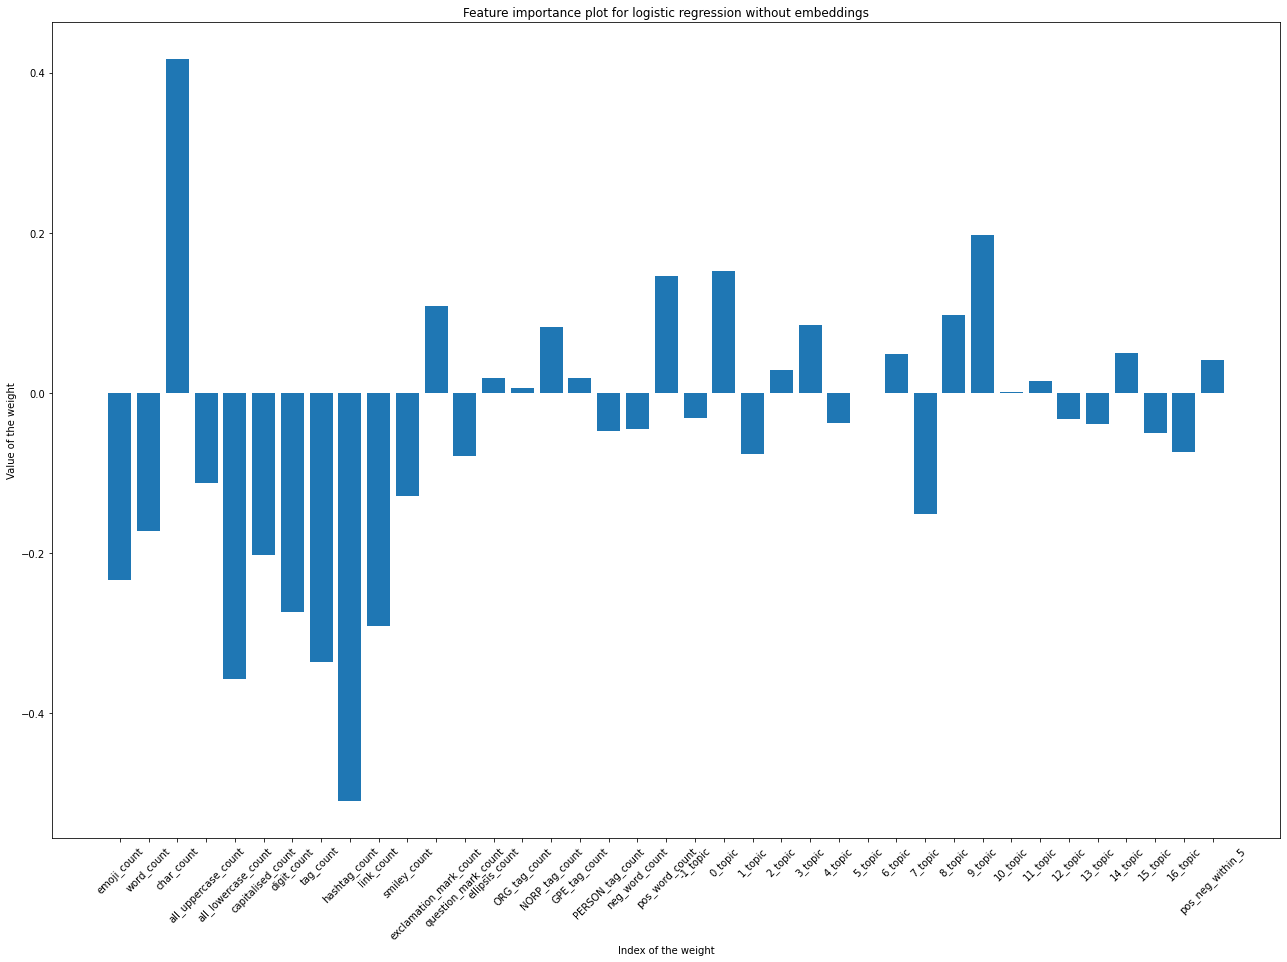

In [82]:
weights = pipeline_lr_best['lr'].coef_.flatten()
weights_wo_embeddings = weights[:18].tolist()
weights_wo_embeddings.extend(weights[-21:])

weights_embeddings = weights[18:318].tolist()

features = x_train.columns.tolist()[:18]
features.extend(x_train.columns.tolist()[-21:])

plt.figure(figsize=(22, 15))
plt.bar(features, weights_wo_embeddings)
plt.ylabel('Value of the weight')
plt.xlabel('Index of the weight')
plt.xticks(rotation = 45) 
plt.title('Feature importance plot for logistic regression without embeddings')
plt.show()

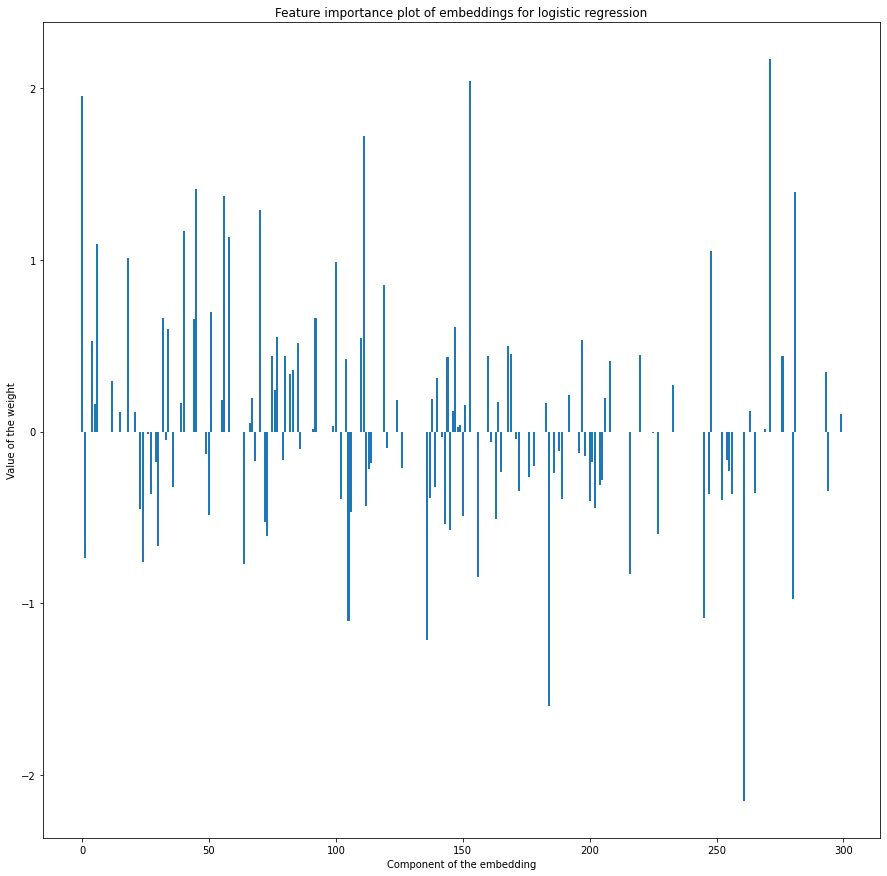

In [83]:
plt.figure(figsize=(15, 15))
plt.bar(list(range(len(weights_embeddings))), weights_embeddings)
plt.ylabel('Value of the weight')
plt.xlabel('Component of the embedding')
plt.title('Feature importance plot of embeddings for logistic regression')
plt.show()

In [ ]:
# pipeline_dtc = Pipeline([
#     ('dtc', DecisionTreeClassifier()),
# ])

# # mozda potrebno pojacat grid, nisam vrtio
# params = {
#     'dtc__max_features': ['auto', 'sqrt', 'log2'],
#     'dtc__ccp_alpha': [0.1, .01, .001],
#     'dtc__max_depth' : list(range(2, 10)),
#     'dtc__criterion' : ['gini', 'entropy', 'log_loss']
# }
# search = GridSearchCV(pipeline_dtc, param_grid=params, cv=5)
# search.fit(x_train, y_train)

# print(f'Best score: {search.best_score_}')
# print(f'Best score: {search.best_params_}')

In [ ]:
# bp = search.best_params_
# pipeline_dtc_best = Pipeline([
#     ('dtc', DecisionTreeClassifier(
#         ccp_alpha=bp['dtc__ccp_alpha'], 
#         criterion=bp['dtc__criterion'], 
#         max_depth=bp['dtc__max_depth'], 
#         max_features=bp['dtc__max_features'])
#     ),
# ])

# model_fit_evaluate(pipeline_dtc_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

In [ ]:
# feat_importances = pipeline_dtc_best['dtc'].feature_importances_.flatten()

# plt.figure(figsize=(5, 5))
# plt.bar(list(range(len(feat_importances))), feat_importances)
# plt.ylabel('Feature importance value')
# plt.xlabel('Index of the feature')
# plt.title('Feature importance plot for decision tree')
# plt.show()

In [474]:
x_train.columns.tolist()

['emoji_count',
 'word_count',
 'char_count',
 'all_uppercase_count',
 'all_lowercase_count',
 'capitalised_count',
 'digit_count',
 'tag_count',
 'hashtag_count',
 'link_count',
 'smiley_count',
 'exclamation_mark_count',
 'question_mark_count',
 'ellipsis_count',
 'ORG_tag_count',
 'NORP_tag_count',
 'GPE_tag_count',
 'PERSON_tag_count',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,


#### Global best without topics

In [84]:
to_drop = ['Label', 'Tweet text', 'Tweet index', 'clean_text', 'lemmas', 'pos_word', 'neg_word', 'topic', 'topic_text']
to_drop = np.concatenate([np.array(to_drop), topic_dummies])

x_train = df_train.drop(columns=to_drop)
x_validation = df_validation.drop(columns=to_drop)
x_test = df_test.drop(columns=to_drop)

In [85]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 100),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'],
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6415586990074054
Best score: {'lr__C': 11.497569953977356, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [86]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.688     0.690     0.689      1340
           1      0.683     0.681     0.682      1316

    accuracy                          0.685      2656
   macro avg      0.685     0.685     0.685      2656
weighted avg      0.685     0.685     0.685      2656
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.690     0.412     0.516       560
           1      0.591     0.820     0.687       579

    accuracy                          0.620      1139
   macro avg      0.640     0.616     0.602      1139
weighted avg      0.639     0.620     0.603      1139
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.774     0.340     0.473       473
           1      0.458     0.849     0.595       31

## Baseline classifiers for the first 4 topics

In [88]:
def get_train_validation_and_test_for_topic(topic_num, df_train, df_validation, df_test, features=baseline_features):
    df_train_topic = df_train[df_train[f'{topic_num}_topic'] == 1]
    df_validation_topic = df_train[df_train[f'{topic_num}_topic'] == 1]
    df_test_topic = df_train[df_train[f'{topic_num}_topic'] == 1]
    
    y_train = df_train_topic['Label']
    x_train = df_train_topic[features]

    y_validation = df_validation_topic['Label']
    x_validation = df_validation_topic[features]

    y_test = df_test_topic['Label']
    x_test = df_test_topic[features]
    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [90]:
features_for_spec_topic = x_train.columns.tolist()[:18]
sentiment_features = x_train.columns.tolist()[-1:]
sentiment_features.extend(x_train.columns.tolist()[318:320])
sentiment_features.extend(features_for_spec_topic)
sentiment_features.extend(x_train.columns.tolist()[18:318])
features_for_spec_topic = sentiment_features

print(features_for_spec_topic)

['pos_neg_within_5', 'neg_word_count', 'pos_word_count', 'emoji_count', 'word_count', 'char_count', 'all_uppercase_count', 'all_lowercase_count', 'capitalised_count', 'digit_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'exclamation_mark_count', 'question_mark_count', 'ellipsis_count', 'ORG_tag_count', 'NORP_tag_count', 'GPE_tag_count', 'PERSON_tag_count', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,

## Best classifier and baseline for the 1st topic

In [98]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(-1, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.603     0.682     0.640       648
           1      0.548     0.462     0.502       541

    accuracy                          0.582      1189
   macro avg      0.576     0.572     0.571      1189
weighted avg      0.578     0.582     0.577      1189
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.603     0.682     0.640       648
           1      0.548     0.462     0.502       541

    accuracy                          0.582      1189
   macro avg      0.576     0.572     0.571      1189
weighted avg      0.578     0.582     0.577      1189
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.603     0.682     0.640       648
           1      0.548     0.462     0.502       54

In [99]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(-1, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 2),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train_, y_train_)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6088891252703613
Best score: {'lr__C': 1000.0, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [100]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.718     0.764     0.740       648
           1      0.694     0.641     0.667       541

    accuracy                          0.708      1189
   macro avg      0.706     0.703     0.704      1189
weighted avg      0.707     0.708     0.707      1189
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.718     0.764     0.740       648
           1      0.694     0.641     0.667       541

    accuracy                          0.708      1189
   macro avg      0.706     0.703     0.704      1189
weighted avg      0.707     0.708     0.707      1189
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.718     0.764     0.740       648
           1      0.694     0.641     0.667       54

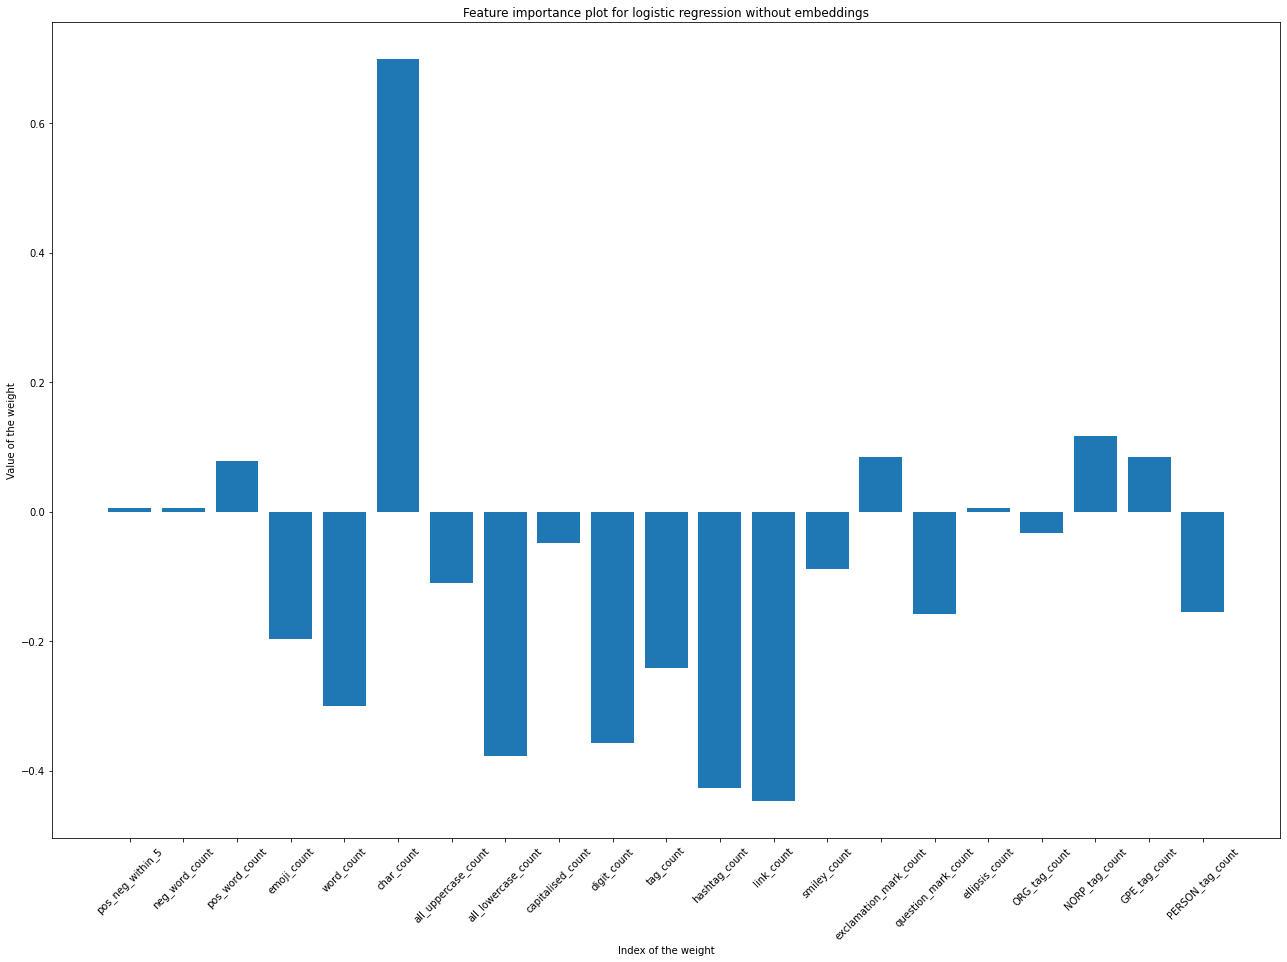

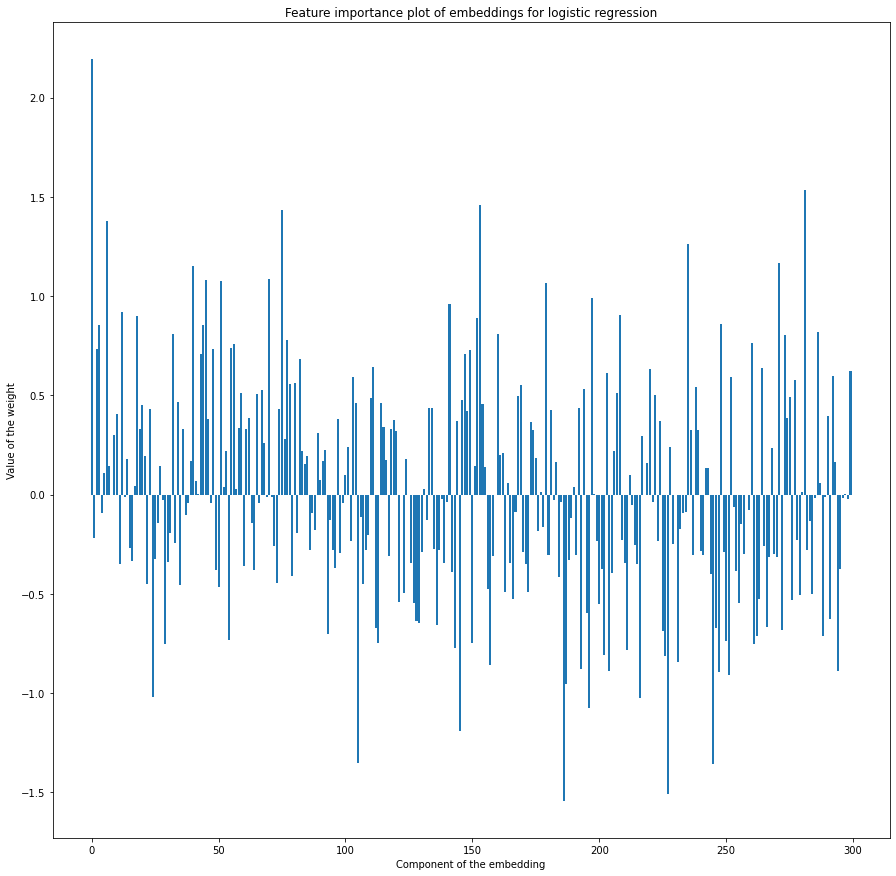

In [101]:
def plot_features_and_embeddings(pipeline, features=features_for_spec_topic):
    weights = pipeline['lr'].coef_.flatten()
    weights_wo_embeddings = weights[:-300].tolist()
    weights_embeddings = weights[-300:].tolist()

    plt.figure(figsize=(22, 15))
    plt.bar(features[:-300], weights_wo_embeddings)
    plt.ylabel('Value of the weight')
    plt.xlabel('Index of the weight')
    plt.xticks(rotation = 45) 
    plt.title('Feature importance plot for logistic regression without embeddings')
    plt.show()
    
    plt.figure(figsize=(15, 15))
    plt.bar(list(range(len(weights_embeddings))), weights_embeddings)
    plt.ylabel('Value of the weight')
    plt.xlabel('Component of the embedding')
    plt.title('Feature importance plot of embeddings for logistic regression')
    plt.show()
    
plot_features_and_embeddings(pipeline_lr_best)

## Best classifier for the 2nd topic

In [102]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(0, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.625     0.372     0.466       121
           1      0.618     0.820     0.705       150

    accuracy                          0.620       271
   macro avg      0.622     0.596     0.586       271
weighted avg      0.621     0.620     0.598       271
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.625     0.372     0.466       121
           1      0.618     0.820     0.705       150

    accuracy                          0.620       271
   macro avg      0.622     0.596     0.586       271
weighted avg      0.621     0.620     0.598       271
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.625     0.372     0.466       121
           1      0.618     0.820     0.705       15

In [103]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(0, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 100),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train_, y_train_)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6196632996632997
Best score: {'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [104]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.598     0.579     0.588       121
           1      0.669     0.687     0.678       150

    accuracy                          0.638       271
   macro avg      0.634     0.633     0.633       271
weighted avg      0.637     0.638     0.638       271
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.598     0.579     0.588       121
           1      0.669     0.687     0.678       150

    accuracy                          0.638       271
   macro avg      0.634     0.633     0.633       271
weighted avg      0.637     0.638     0.638       271
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.598     0.579     0.588       121
           1      0.669     0.687     0.678       15

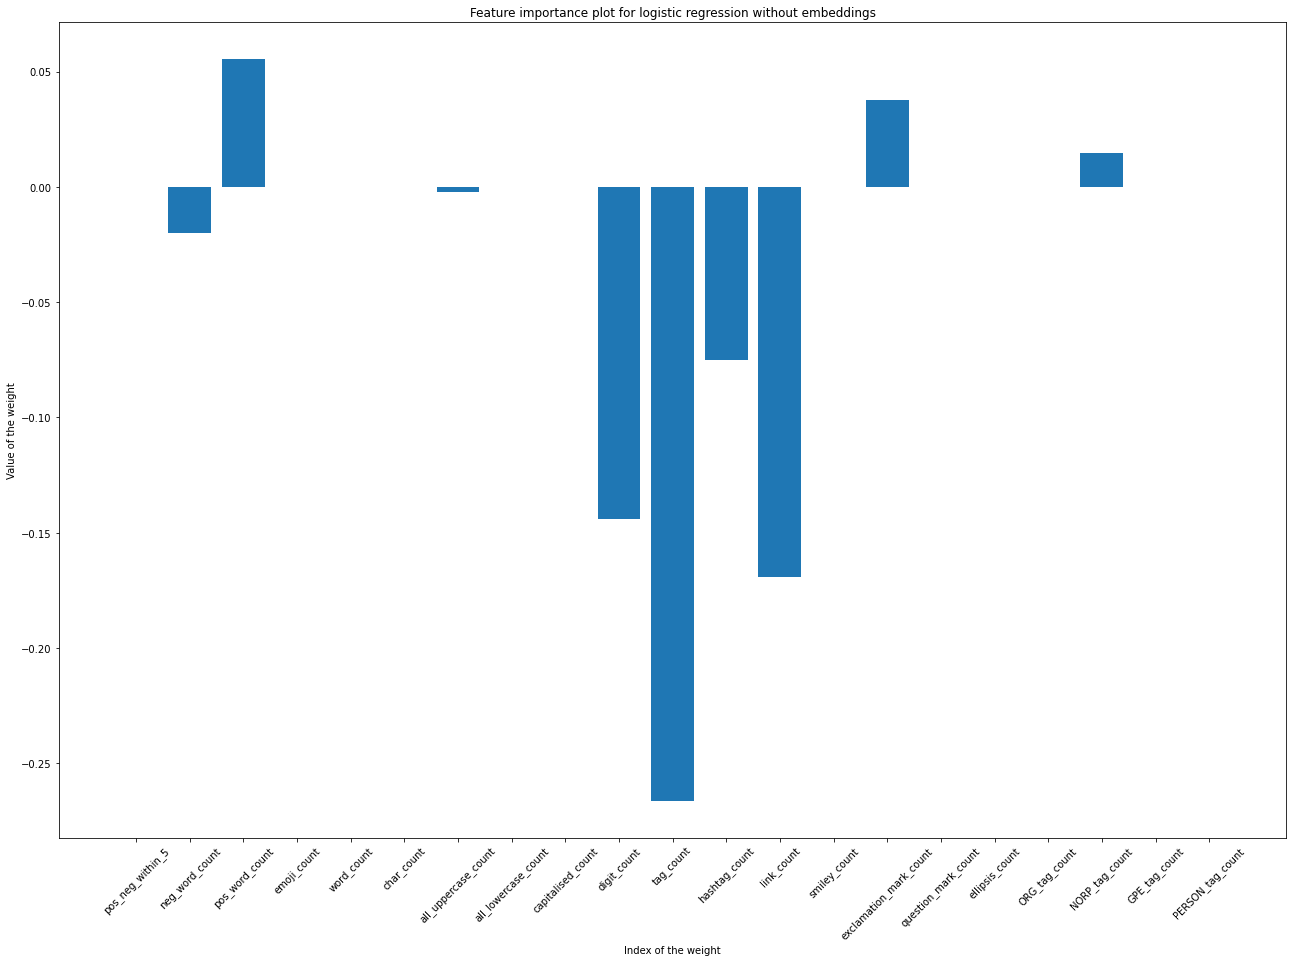

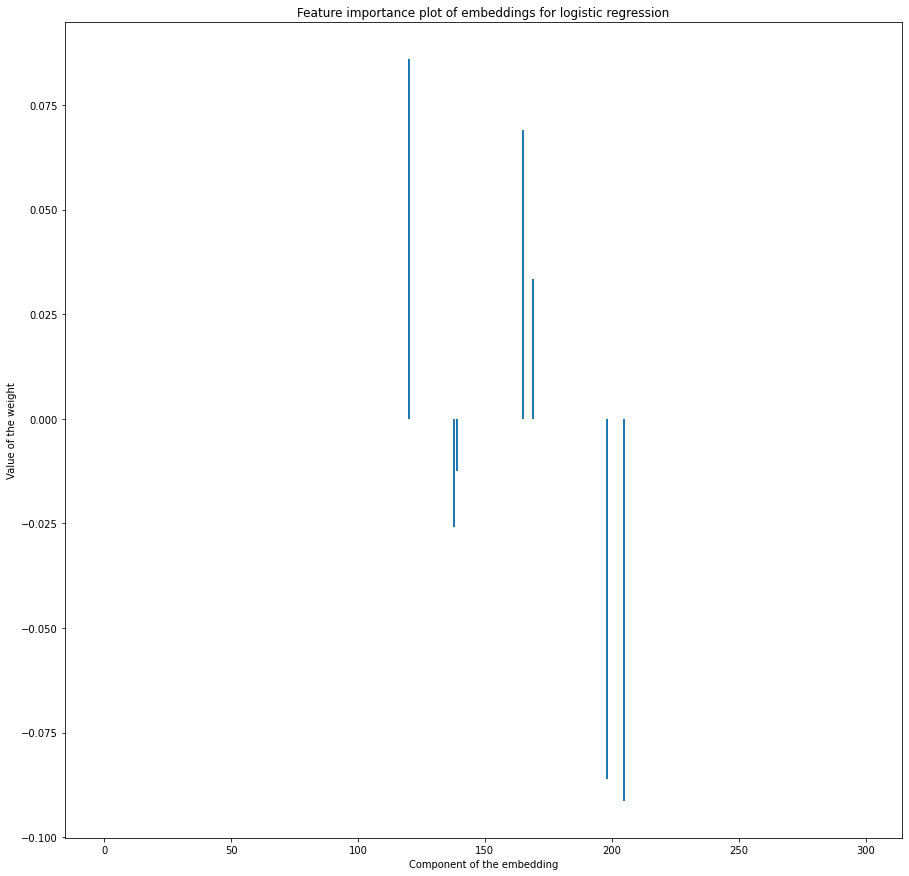

In [105]:
plot_features_and_embeddings(pipeline_lr_best)

## Best classifier for the 3rd topic

In [106]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(1, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      1.000     0.022     0.043        46
           1      0.664     1.000     0.798        89

    accuracy                          0.667       135
   macro avg      0.832     0.511     0.420       135
weighted avg      0.779     0.667     0.541       135
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      1.000     0.022     0.043        46
           1      0.664     1.000     0.798        89

    accuracy                          0.667       135
   macro avg      0.832     0.511     0.420       135
weighted avg      0.779     0.667     0.541       135
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      1.000     0.022     0.043        46
           1      0.664     1.000     0.798        8

In [107]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(1, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 100),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train_, y_train_)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.725925925925926
Best score: {'lr__C': 0.1747528400007683, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [108]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.800     0.609     0.691        46
           1      0.820     0.921     0.868        89

    accuracy                          0.815       135
   macro avg      0.810     0.765     0.780       135
weighted avg      0.813     0.815     0.808       135
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.800     0.609     0.691        46
           1      0.820     0.921     0.868        89

    accuracy                          0.815       135
   macro avg      0.810     0.765     0.780       135
weighted avg      0.813     0.815     0.808       135
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.800     0.609     0.691        46
           1      0.820     0.921     0.868        8

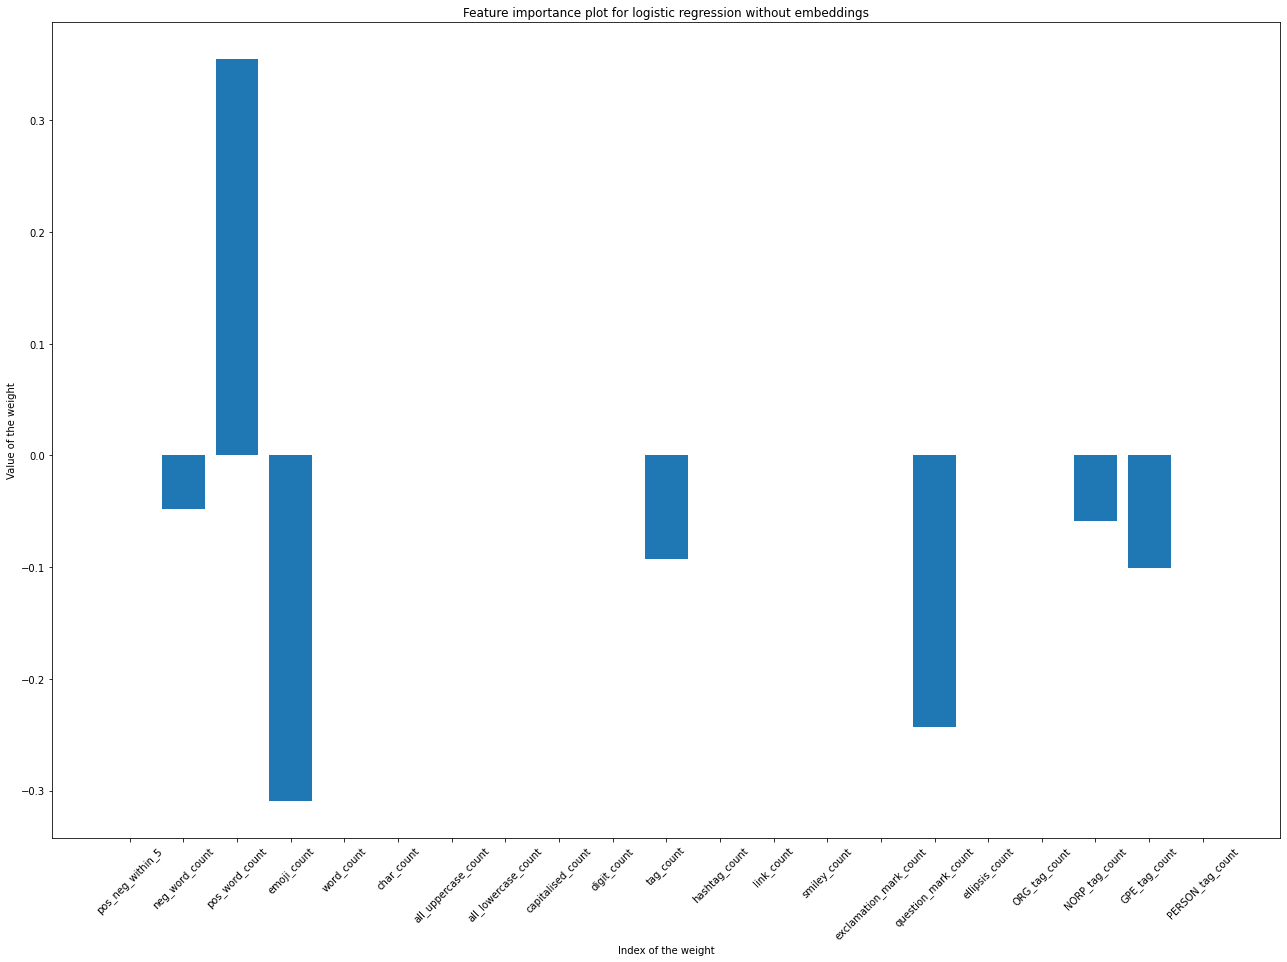

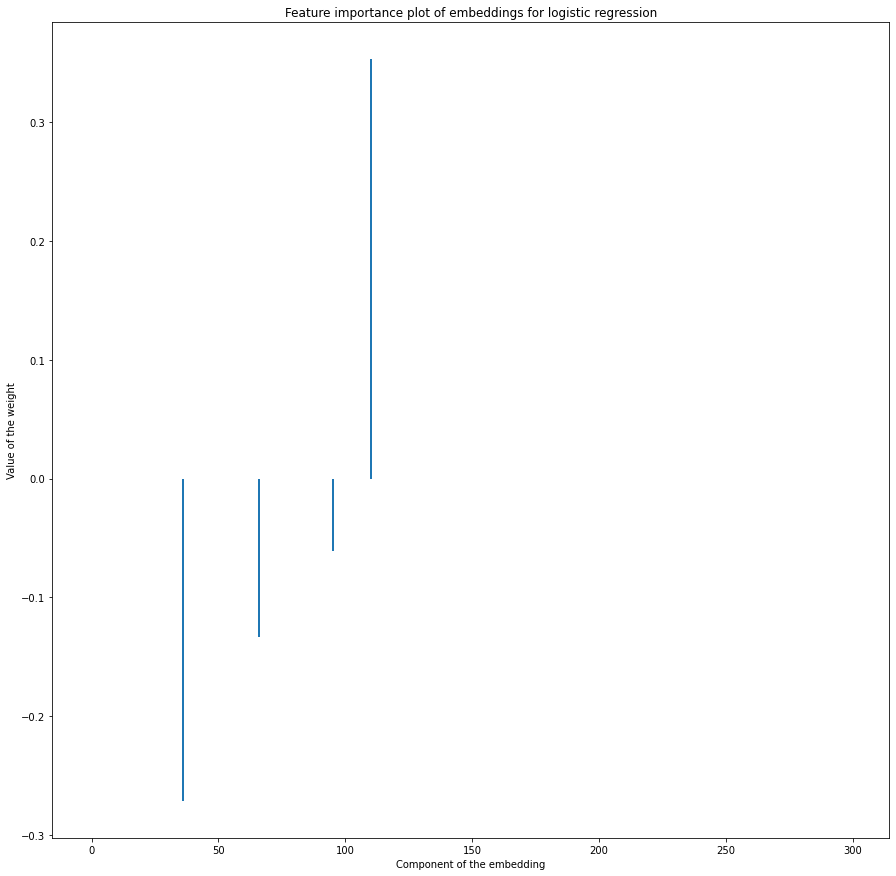

In [109]:
plot_features_and_embeddings(pipeline_lr_best)

## Best classifier for the 4th topic

In [110]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(2, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.720     0.750     0.735        72
           1      0.647     0.611     0.629        54

    accuracy                          0.690       126
   macro avg      0.684     0.681     0.682       126
weighted avg      0.689     0.690     0.689       126
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.720     0.750     0.735        72
           1      0.647     0.611     0.629        54

    accuracy                          0.690       126
   macro avg      0.684     0.681     0.682       126
weighted avg      0.689     0.690     0.689       126
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.720     0.750     0.735        72
           1      0.647     0.611     0.629        5

In [111]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(2, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 100),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train_, y_train_)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.572
Best score: {'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [112]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.692     0.500     0.581        72
           1      0.514     0.704     0.594        54

    accuracy                          0.587       126
   macro avg      0.603     0.602     0.587       126
weighted avg      0.616     0.587     0.586       126
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.692     0.500     0.581        72
           1      0.514     0.704     0.594        54

    accuracy                          0.587       126
   macro avg      0.603     0.602     0.587       126
weighted avg      0.616     0.587     0.586       126
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.692     0.500     0.581        72
           1      0.514     0.704     0.594        5

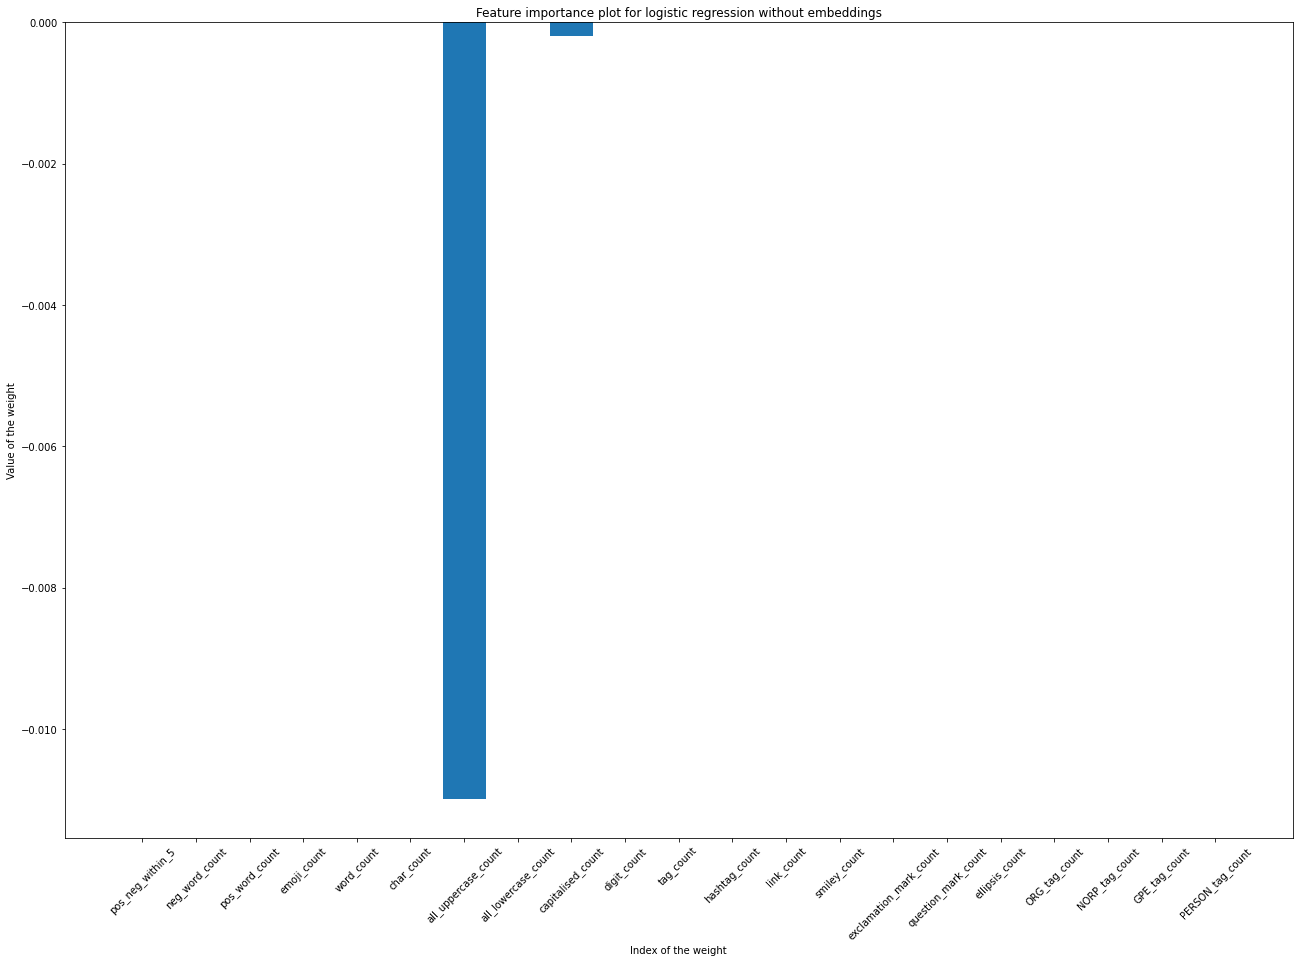

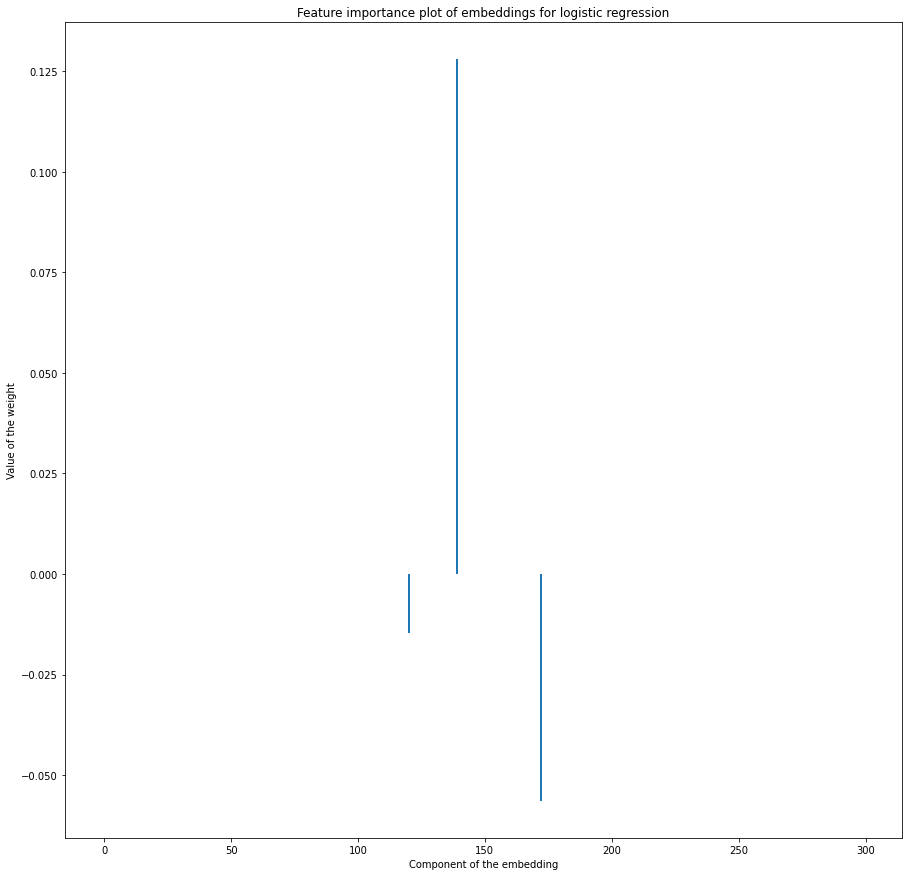

In [113]:
plot_features_and_embeddings(pipeline_lr_best)

## Permutation test to determine whether topic affects (global)